In [12]:
!pip install xgboost

  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)


In [15]:
# Import Data Manipulation Library
import numpy as np
import pandas as pd 
# Import Data Visualization Library
import seaborn as sns
import matplotlib.pyplot as plt 
# Import Filter Warning Library
import warnings 
warnings.filterwarnings('ignore')
# Import Scikit Learn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,f1_score
import joblib
import time
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# Import Dataset using Pandas Function


file_path = r"c:\EnE_PredictiveMaintainanceModel\ml_project\data\predictive_maintenance.csv"
df = pd.read_csv(file_path)

df.sample(frac = 1)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
636,637,L47816,L,298.3,309.9,1463,43.9,116,0,No Failure
8360,8361,L55540,L,298.6,309.6,1540,35.8,5,0,No Failure
6413,6414,L53593,L,300.4,310.1,1614,33.5,191,0,No Failure
4523,4524,L51703,L,302.5,310.4,1488,48.4,134,0,No Failure
6622,6623,L53802,L,301.7,310.7,1493,51.1,87,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
5471,5472,L52651,L,302.7,312.3,1346,61.2,170,0,Random Failures
494,495,L47674,L,297.6,309.4,1326,49.8,199,0,No Failure
46,47,M14906,M,298.7,309.0,1843,25.8,130,0,No Failure
3645,3646,L50825,L,302.2,311.5,1413,43.5,83,0,No Failure


In [3]:
# Checking Dataset Information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
df = df.drop(columns=["UDI", "Product ID"])

In [5]:
# EDA: Checking Univariate Stats

from collections import OrderedDict

stats = []

# Descriptive statistics
for col in df.columns:
    if df[col].dtype != 'object':
        numerical_stats = OrderedDict({
            'Feature': col,
            'Minimum': df[col].min(),
            'Maximum': df[col].max(),
            'Mean': df[col].mean(),
            'Mode': df[col].mode()[0] if not df[col].mode().empty else None,
            '25%': df[col].quantile(0.25),
            '75%': df[col].quantile(0.75),
            'IQR': df[col].quantile(0.75) - df[col].quantile(0.25),
            'Standard Deviation': df[col].std(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurt()
        })
        stats.append(numerical_stats)

# Convert to DataFrame
report = pd.DataFrame(stats)

# Outlier Identification :
outlier_label = []
for col in report['Feature']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR   # LW : Lower Whisker Line
    UW = Q3 + 1.5 * IQR   # UW : Upper Whisker Line
    outliers = df[(df[col] < LW) | (df[col] > UW)]
    if not outliers.empty:
        outlier_label.append("Has Outliers")
    else:
        outlier_label.append("No Outliers")

report["Outlier Comment"] = outlier_label

# Checking Report
report

,Feature,Minimum,Maximum,Mean,Mode,25%,75%,IQR,Standard Deviation,Skewness,Kurtosis,Outlier Comment
0,Air temperature [K],295.3,304.5,300.00493,300.7,298.3,301.5,3.2,2.000259,0.114274,-0.835962,No Outliers
1,Process temperature [K],305.7,313.8,310.00556,310.6,308.8,311.1,2.3,1.483734,0.015027,-0.499734,No Outliers
2,Rotational speed [rpm],1168.0,2886.0,1538.77610,1452.0,1423.0,1612.0,189.0,179.284096,1.993171,7.392945,Has Outliers
3,Torque [Nm],3.8,76.6,39.98691,40.2,33.2,46.8,13.6,9.968934,-0.009517,-0.013241,Has Outliers
4,Tool wear [min],0.0,253.0,107.95100,0.0,53.0,162.0,109.0,63.654147,0.027292,-1.166737,No Outliers
5,Target,0.0,1.0,0.03390,0.0,0.0,0.0,0.0,0.180981,5.151852,24.546486,Has Outliers


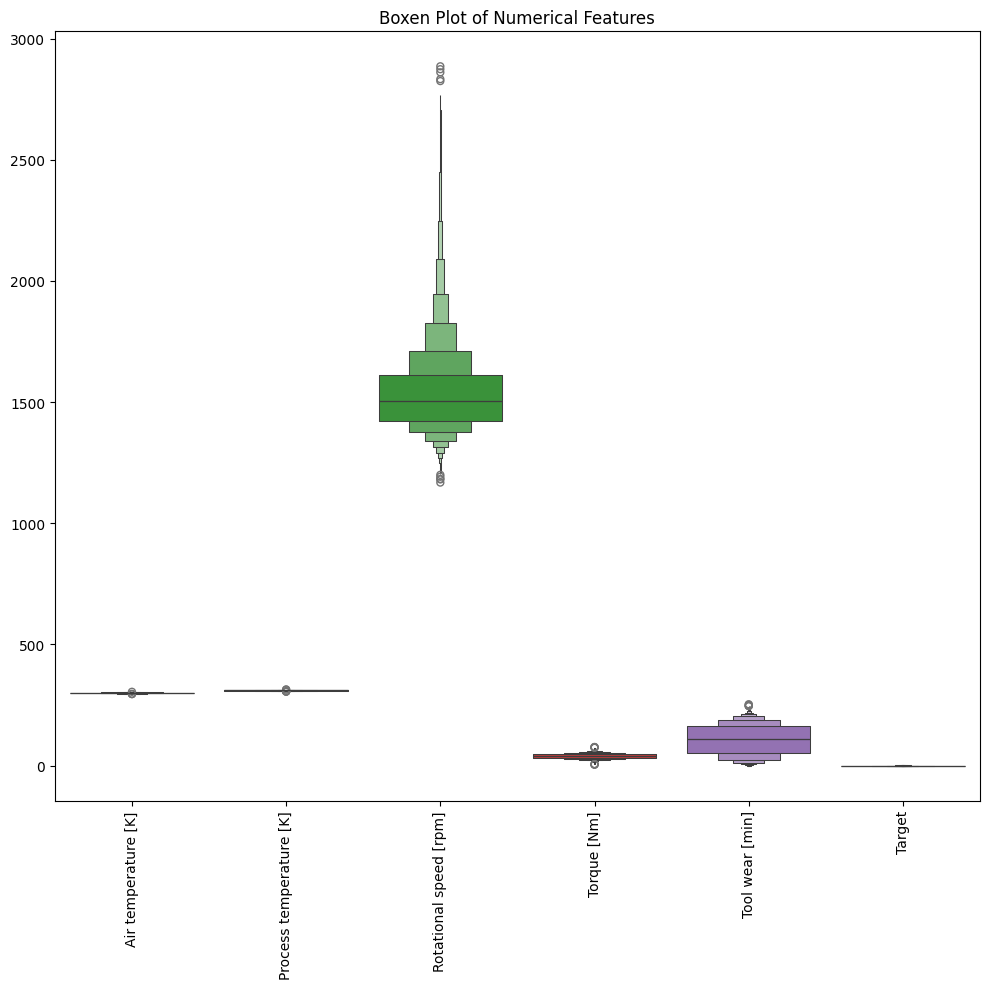

In [6]:
# Checking BoxenPlot 
plt.figure(figsize=(10, 10))
sns.boxenplot(data= df)

plt.xticks(rotation = 90)  
plt.title("Boxen Plot of Numerical Features")
plt.tight_layout()
plt.show()

In [7]:
# Replace Outliers with Median Statergy
'''
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outliers.sum()

    if outlier_count > 0:
        replacement = df[col].median()  
        df.loc[outliers, col] = replacement
        print(f"Replaced {outlier_count} outliers in '{col}' with median.")
    else:
        print(f"No outliers found in '{col}'.")
        
'''

'\nfor col in df.select_dtypes(include=\'number\').columns:\n    Q1 = df[col].quantile(0.25)\n    Q3 = df[col].quantile(0.75)\n    IQR = Q3 - Q1\n\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    # Identify outliers\n    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)\n    outlier_count = outliers.sum()\n\n    if outlier_count > 0:\n        replacement = df[col].median()  \n        df.loc[outliers, col] = replacement\n        print(f"Replaced {outlier_count} outliers in \'{col}\' with median.")\n    else:\n        print(f"No outliers found in \'{col}\'.")\n\n'

In [8]:
df['Type'] = df['Type'].replace({'L':0,'M':1,'H':2})
df["Failure Type"] = df["Failure Type"].replace({
    "No Failure": 0,
    "Heat Dissipation Failure": 1,
    "Power Failure": 2,
    "Overstrain Failure": 3,
    "Tool Wear Failure": 4,
    "Random Failures": 5})

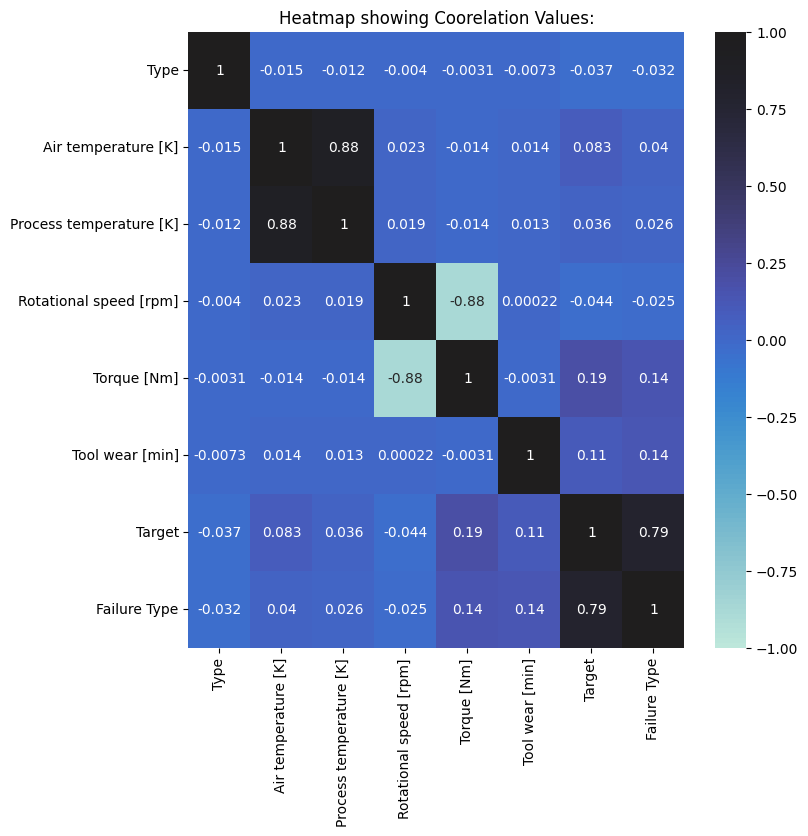

In [9]:
# Checking Correlation 
corr = df.corr()
df.ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr,annot = True,center = True,vmax= 1,vmin = -1)
plt.title('Heatmap showing Coorelation Values:')
plt.show()

In [18]:
X = df.drop(columns=["Failure Type"])
y = df["Failure Type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Columns
num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(exclude="number").columns.tolist()

# Pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

oversampler = SMOTE(random_state=42)

# Candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "Gaussian NB": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier()
}

results = {}

print("Training Models...\n")

for name, model in models.items():
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("oversample", oversampler),
        ("classifier", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    weighted_f1 = accuracy_score(y_test, y_pred)
    results[name] = weighted_f1
    print(f"{name}: Accuracy Score = {weighted_f1:.4f}")

# Sort and print
print("Best Models:")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")

Training Models...

Logistic Regression: Accuracy Score = 0.6610
Decision Tree: Accuracy Score = 0.9800
Random Forest: Accuracy Score = 0.9875
Gradient Boosting: Accuracy Score = 0.9505
AdaBoost: Accuracy Score = 0.9765
K-Nearest Neighbors: Accuracy Score = 0.9690
SVC: Accuracy Score = 0.8035
Gaussian NB: Accuracy Score = 0.0915
XGBoost: Accuracy Score = 0.9850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 46332, number of used features: 7
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [In